In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
print(jax.__version__)

2.15.0
0.4.26


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_TFREC = "/kaggle/input/leap-train-tfrecords"

In [5]:
sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"), n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']

In [7]:
train_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100)]
valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

In [8]:
BATCH_SIZE = 1024*4

train_options = tf.data.Options()
train_options.deterministic = True

ds_train = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .with_options(train_options)
    .shuffle(100)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE),
        num_parallel_calls=tf.data.AUTOTUNE,
        cycle_length=10,
        block_length=1000,
        deterministic=True
    )
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
norm_x = keras.layers.Normalization()


In [10]:
norm_y = keras.layers.Normalization()



In [11]:
with open("/kaggle/input/leapnorms/norm_x_mean.npy","rb") as file:
   norm_x_mean= np.load(file)

with open("/kaggle/input/leapnorms/norm_x_variance.npy","rb") as file:
   norm_x_variance= np.load(file)

with open("/kaggle/input/leapnorms/norm_y_mean.npy","rb") as file:
    norm_y_mean= np.load(file)

with open("/kaggle/input/leapnorms/norm_y_variance.npy","rb") as file:
     norm_y_variance= np.load(file)

In [12]:


mean_y =tf.constant(norm_y_mean)
stdd_y = keras.ops.maximum(1e-10,tf.constant(norm_y_variance) ** 0.5)



### Model definition & Training

In [13]:
import jax.numpy as jnp

In [14]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        
        vals_clipped = keras.ops.clip(self.base_metric.result(), 0.0, 1.0)

    # Drop NaNs by replacing them with zeros
        vals_clipped = jnp.where(jnp.isnan(vals_clipped), jnp.zeros_like(vals_clipped), vals_clipped)
    
    # Calculate the mean of the clipped values
        return jnp.mean(vals_clipped)
      
        
    def reset_states(self):
        self.base_metric.reset_states()

In [15]:
@keras.saving.register_keras_serializable()


def r2_mult_keras(y_true, y_pred):

    SS_res =  tf.reduce_sum((y_true - y_pred),axis=0)
    SS_tot = tf.reduce_sum((y_true - tf.reduce_mean(y_true, axis=0 )),axis=0)
    vals = 1 - SS_res/(SS_tot+0.00000000001)
    vals_clipped = tf.where(vals < 0, tf.zeros_like(vals), vals)


    return     tf.reduce_mean(vals_clipped )

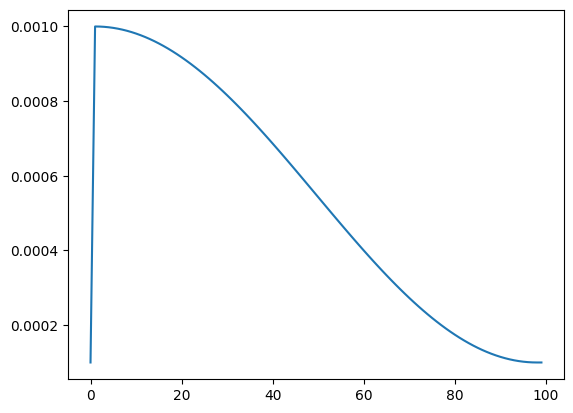

In [16]:
epochs = 100  # 25  # 15  # 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    1e-4, 
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)]);

In [17]:
keras.utils.clear_session()

import keras
def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)


def build_cnn(activation='relu'):
    return keras.Sequential([
        keras.layers.Conv1D(512, 5, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 5, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 7, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
    ])

def build_cnn1(activation='relu'):
    return keras.Sequential([
        keras.layers.Conv1D(512, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
    ])


X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
x = keras.layers.Normalization(mean=tf.constant( norm_x_mean), variance=tf.constant( norm_x_variance))(x)
x = x_to_seq(x)


e = e0 = keras.layers.Conv1D(128, 1, padding='same')(x)
e1 = build_cnn()(e)
e2 = build_cnn1()(e)

e=tf.keras.layers.Add()([e0,e1])
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)


e1 = build_cnn()(e)
e2 = build_cnn1()(e)

e=tf.keras.layers.Add()([e0,e1])
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)

# add global average to allow some comunication between all levels even in a small CNN

e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e) + build_cnn1()(e)


p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 360

p_flat = p_all[:, :, 6:6 + 8]
p_flat = keras.ops.mean(p_flat, axis=1)
assert p_flat.shape[-1] == 8

P = keras.ops.concatenate([p_seq, p_flat], axis=1)

# build & compile
model = keras.Model(X_input, P)
model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 128)   │      3,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 128)   │  1,216,896 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 128)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 128)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 128)    │          0 │ add[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 128)   │          0 │ add_1[0][0],      │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,348,942 (16.59 MB)

 Trainable params: 4,341,518 (16.56 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [18]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))
TRAIN = False
if TRAIN:
    history = model.fit(
        ds_train_target_normalized,
        validation_data=ds_valid_target_normalized,
        epochs=epochs,
        verbose=1 if is_interactive() else 2,
        callbacks=[
            keras.callbacks.ModelCheckpoint(filepath='model.keras')
        ]
    )
else:
    model = keras.models.load_model('/kaggle/input/leap-keras-models/big_cnn_large_dataset_v3.keras')

In [19]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

I0000 00:00:1720995587.897676      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-14 22:19:47.900965: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


23/23 ━━━━━━━━━━━━━━━━━━━━ 428s 19s/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


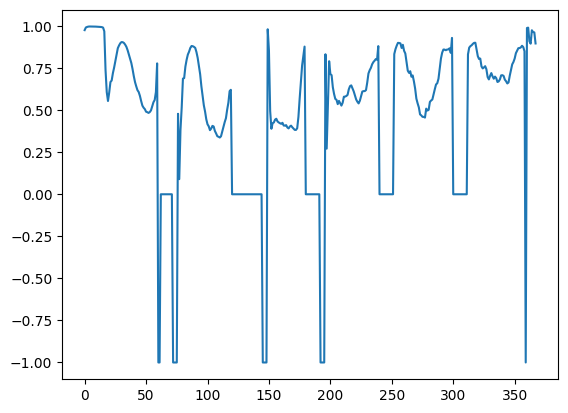

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

In [21]:
import numpy as np

In [22]:
with open(f"scores.npy","wb") as file:
    np.save(file,scores_valid)

In [23]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

'Number of under-performing targets: 86'

In [24]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

'Clipped score: 0.5233078955675239'

In [25]:
del y_valid, p_valid
gc.collect();

# Submission

In [26]:
sample = pl.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

In [27]:
df_test = (
    pl.scan_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv")
    .select(pl.exclude("sample_id"))
    .cast(pl.Float32)
    .collect()
)

In [ ]:
p_test = model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) * stdd_y.numpy() + mean_y.numpy()
print(mean_y.numpy().shape)

p_test[:, mask] = mean_y.numpy()[:, mask]

 3/39 ━━━━━━━━━━━━━━━━━━━━ 47:18 79s/step

In [ ]:
 mean_y.numpy().shape

In [ ]:
  p_test.shape

In [ ]:
# correction of ptend_q0002 targets (from 12 to 29)
df_p_test = pd.DataFrame(p_test, columns=TARGETS)

for idx in range(12, 30):
    df_p_test[f"ptend_q0002_{idx}"] = -df_test[f"state_q0002_{idx}"].to_numpy() / 1200
    
p_test = df_p_test.values

In [ ]:
submission = sample.to_pandas()
submission[TARGETS] =  p_test
pl.from_pandas(submission[["sample_id"] + TARGETS]).write_csv("submission.csv")